In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch

import sys
sys.path.append('../src')

embedding_dir = '../data/pjm_models/embeddings/15epochs'

In [3]:
# CLONAL EXPANSION
name = 'jing_clonal_expansion'
n_pcs = 16
model_name = f'pjm_15epochs_pca{n_pcs}'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
y = pd.read_csv(y_path)['Y'].values
sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_betaseqs_raw.csv', index_col=0)

# # JING TUMOR
# name = 'jing_tumor'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_y2.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/0.05_0.5_out'
# y = pd.read_csv(y_path)['y'].values
# sequences = pd.read_csv('/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/filtered_x2_cdr3_b.csv')

# # ANTIGEN SPECIFICITY
# name = 'alok_antigen_specificity'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv' 
# y = pd.read_csv(y_path)['Antigen'].values - 1
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_seqs.csv', index_col=0)['beta']

In [4]:
from util import remove_empty_tcrs, get_sigLFs

z1s = get_sigLFs(slide_outs)
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[z1s]
z_matrix.shape

(10191, 5)

In [5]:
from util import remove_empty_tcrs

sequences, y, z_matrix = remove_empty_tcrs(sequences, y, z_matrix)
sequences.shape, y.shape, z_matrix.shape

((10191,), (10191,), (10191, 5))

### Get embeddings from pjm model

In [16]:
import sys
sys.path.append('../src/pjm')

from pjm import from_pretrained, build_default_alphabet

alphabet = build_default_alphabet()

# Load encoder
embedder = from_pretrained(
    model_type="mmplm",
    alphabet=alphabet,
    checkpoint_path='../data/pjm_models/mmplm_15epochs_dim256_ckpt.pth',
)

In [17]:
tokenizer = alphabet.get_batch_converter()

batch_labels = sequences.astype(str)
seq_str_list = sequences.astype(str)
raw_batch = list(zip(batch_labels, seq_str_list))

labels, strs, tokens = tokenizer(raw_batch)

In [18]:
embeddings = embedder(tokens)
embeddings.shape

torch.Size([73, 17, 256])

In [ ]:
embeddings = embeddings.detach().numpy()
np.save(os.path.join(embedding_dir, f'{name}.npy'), embeddings)

### Embedding interactions

In [7]:
embeddings = np.load(os.path.join(embedding_dir, f'{name}.npy'))
embeddings = embeddings.reshape(embeddings.shape[0], -1)
embeddings.shape

(10191, 7424)

In [9]:
from sklearn.decomposition import PCA

model = PCA(n_components=n_pcs)
model.fit(embeddings)
tcr_embeddings = model.transform(embeddings)
tcr_embeddings.shape

(10191, 16)

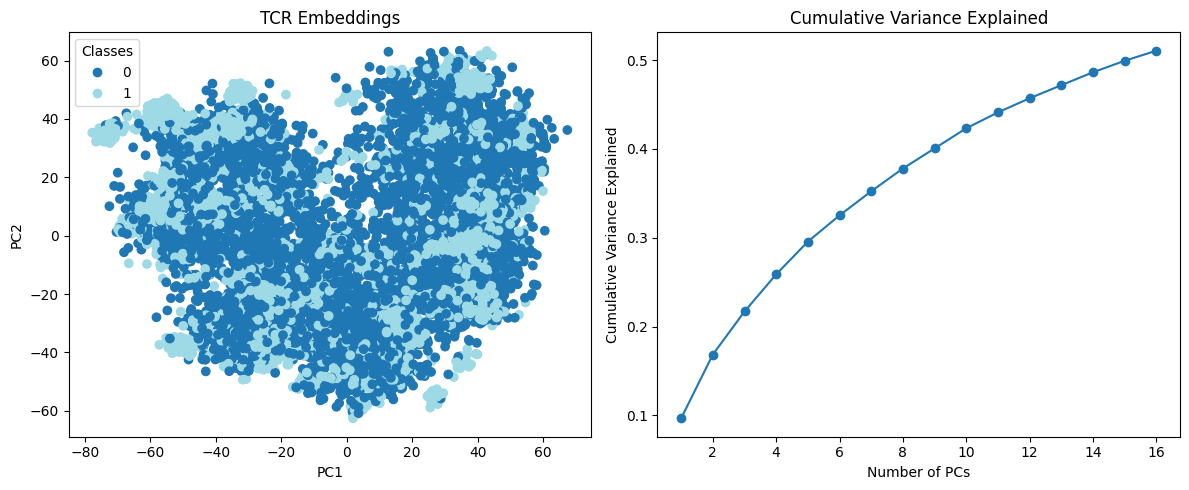

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
scatter = ax[0].scatter(tcr_embeddings[:, 0], tcr_embeddings[:, 1], c=y, cmap='tab20')
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('TCR Embeddings')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# Cumulative variance explained plot
cumsum_variance = np.cumsum(model.explained_variance_ratio_)
ax[1].plot(range(1, n_pcs+1), cumsum_variance, marker='o')
ax[1].set_title('Cumulative Variance Explained')
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Cumulative Variance Explained')

plt.tight_layout()
os.makedirs(f'../results/plm/{name}', exist_ok=True)
plt.savefig(f'../results/plm/{name}/{model_name}_pca.png')
plt.show()


In [40]:
tcr_embeddings.mean(), tcr_embeddings.max(), tcr_embeddings.min()

(-3.7731476e-07, 75.47691, -77.73989)

In [41]:
z_matrix.mean(), z_matrix.max(), z_matrix.min()

(6.247142490835539e-17, 2.23645786229341, -2.05381328943911)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(z_matrix.min(), z_matrix.max()))
scaler.fit(tcr_embeddings)
tcr_embeddings = scaler.transform(tcr_embeddings)

In [43]:
import sys
sys.path.append('../src')

from interaction import Interaction

machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, 
    y=y,
    z_matrix=z_matrix,
    interacts_only=False,
    model='LR'
)

machop.get_sig_interactions(fdr=0.5, n_iters=20, thresh=0.8)
# machop.get_sig_interactions(fdr=0.5, n_iters=20, thresh=0.5)

100%|██████████| 20/20 [05:51<00:00, 17.57s/it]

Found 24 significant interactions with AUC=0.8047241258103709


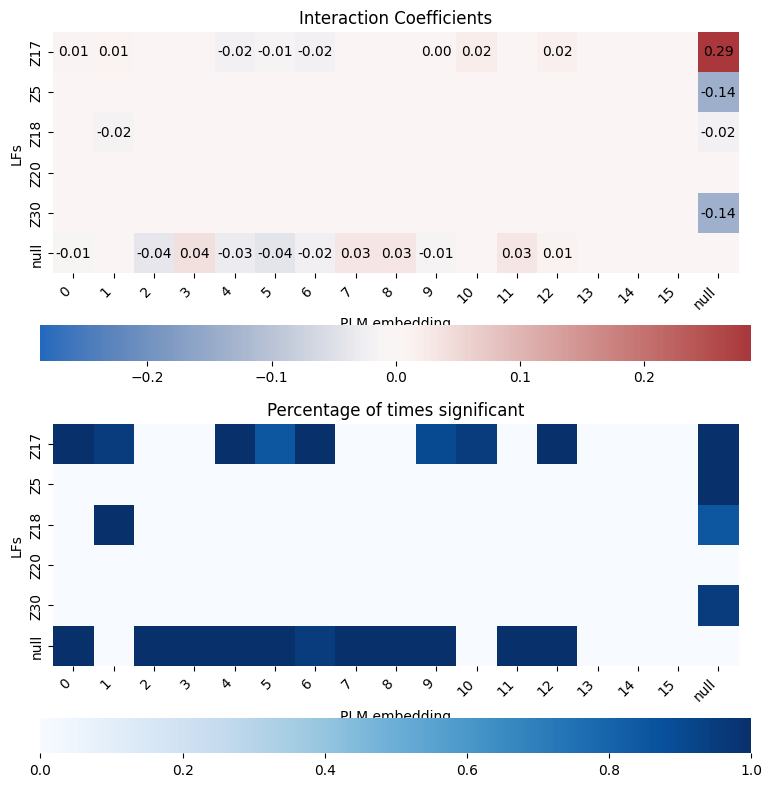

In [44]:
from plotting import show_interactions
show_interactions(machop, save_path=f'../results/plm/{name}/{model_name}_betas.png')

In [24]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(10191, 24)

In [25]:
np.save(f'../results/plm/{name}/{model_name}_joint_embed.npy', joint_embed)

In [26]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(10191, 23)

In [45]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.05)
# model = LinearRegression()

In [46]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)

estimator = Estimator(model=model)
auc1 = estimator.evaluate(full_embed, y)

estimator = Estimator(model=model)
auc2 = estimator.evaluate(machop.z_matrix, y)

estimator = Estimator(model=model)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [47]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01


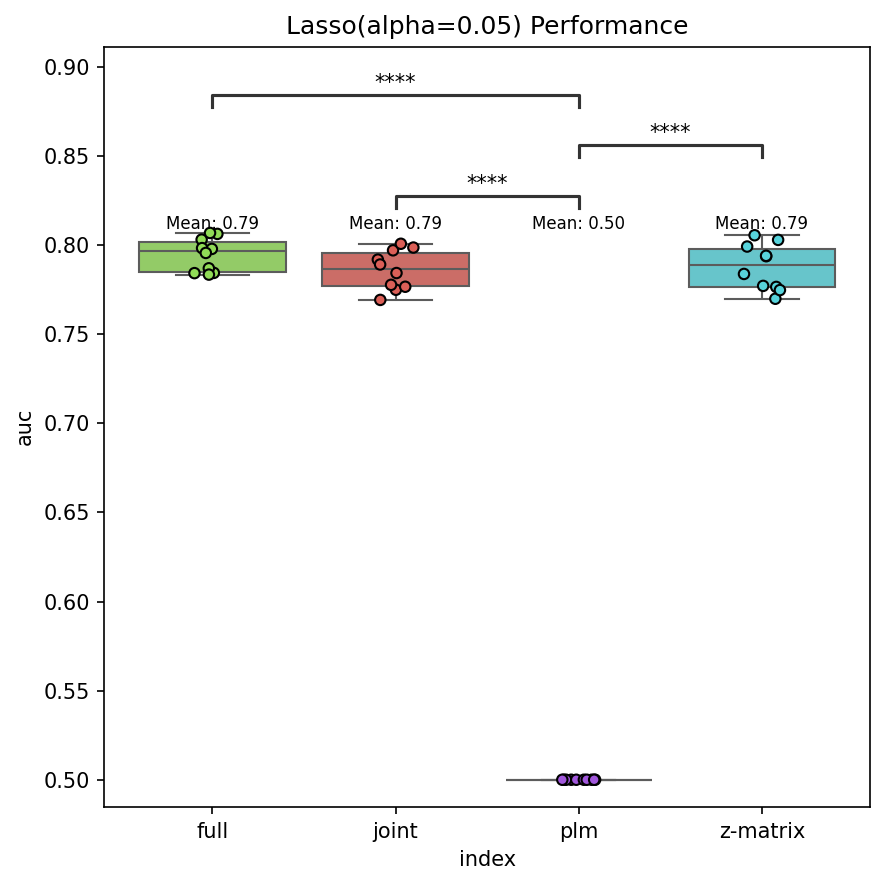

In [48]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'../results/plm/{name}/{model_name}_{model.__class__.__name__}_performance.png')

Found 21 significant interactions with AUC=1.0


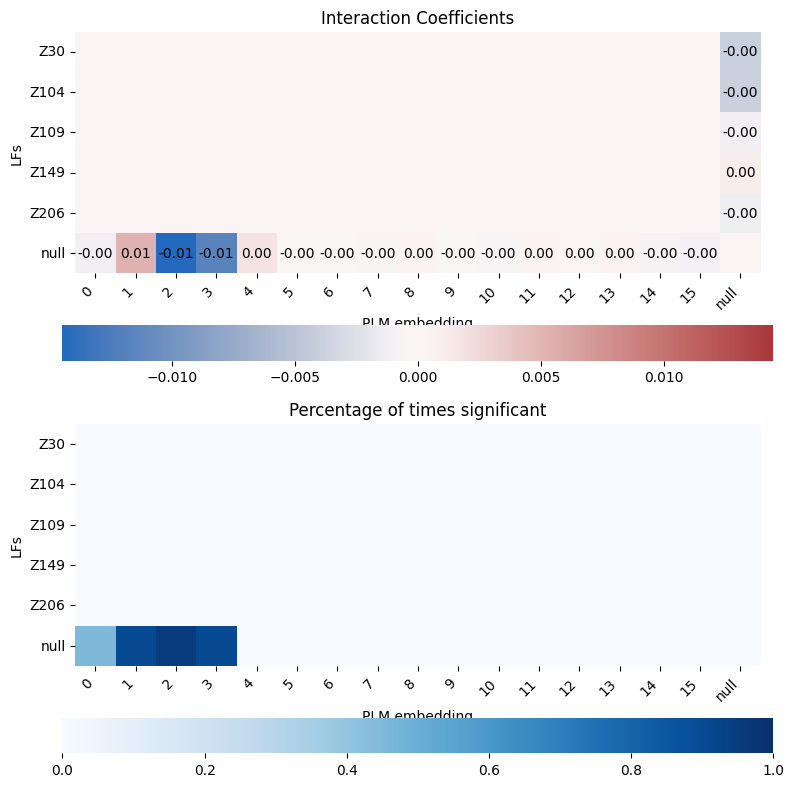

In [42]:
machop.force_linear_terms(z1=True, z2=True)

from plotting import show_interactions
show_interactions(machop, save_path=f'../results/plm/{name}/{model_name}_betas_wlinear.png')


In [43]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(73, 21)

In [44]:
np.save(f'../results/plm/{name}/{model_name}_joint_embed_wlinear.npy', joint_embed)

In [45]:
model = Lasso(alpha=0.05)
# model = LinearRegression()

In [46]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)

estimator = Estimator(model=model)
auc1 = estimator.evaluate(full_embed, y)

estimator = Estimator(model=model)
auc2 = estimator.evaluate(machop.z_matrix, y)

estimator = Estimator(model=model)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [47]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

full vs. joint: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.277e-02 Stat=6.201e+00
joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.277e-02 Stat=6.201e+00
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.760e-05 Stat=1.758e+01
joint vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.154e-04 Stat=1.298e+01
full vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.760e-05 Stat=1.758e+01


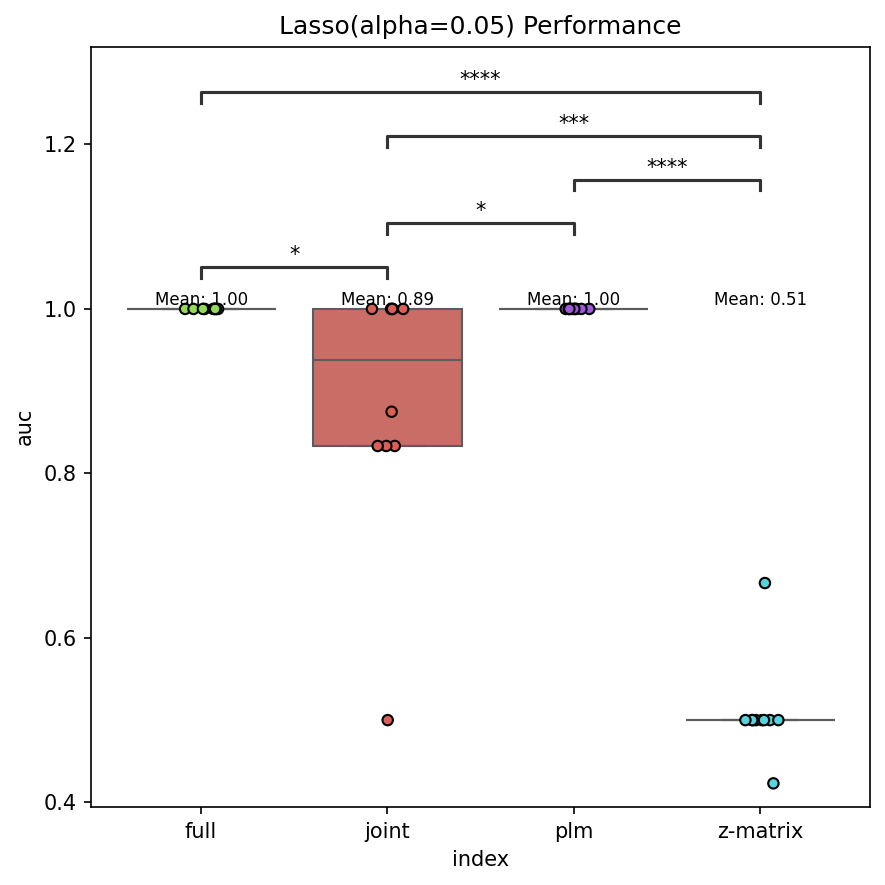

In [48]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'../results/plm/{name}/{model_name}_{model.__class__.__name__}_performance_wlinear.png')